In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io

## 1. Load dataset

- BBC dataset : 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.
    - Dataset is broken into 1490 records for training and 735 for testing
- Goal : Build a system that can accurately classify previously unseen news articles into the right category

In [2]:
# Load dataset
df = pd.read_csv('Datasets/bbc-text.csv')
display(df.head())

news_labels = df.iloc[:,0].values
news_text_orig = df.iloc[:,1].values
print(news_labels.shape,news_text_orig.shape)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


(2225,) (2225,)


##### Remove stopwords

- One important step when working with text data is to remove the stopwords from it. These are the most common words in the language and they rarely provide useful information for the classification process.

In [3]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    sentence = sentence.lower()
    result = ''
    for word in sentence.split():
        if word not in stopwords:
            result += word + ' '
    return result.strip()   #remove leading and trailing whitespaces

print("Check => ",remove_stopwords("I am about to go to the store and get some snack"))

Check =>  go store get snack


In [4]:
news_text = []
for txt in news_text_orig:
    news_text.append(remove_stopwords(txt))
news_text = np.array(news_text)
print(news_text_orig.shape,news_text.shape)
print(len(news_text_orig[0].split()),len(news_text[0].split()))

(2225,) (2225,)
737 436


In [6]:
news_text_train, news_text_test, news_labels_train, news_labels_test = train_test_split(news_text,
                                                                                        news_labels,
                                                                                        test_size=0.2)
news_text_train = np.array(news_text_train)
news_labels_train = np.array(news_labels_train)
news_text_test = np.array(news_text_test)
news_labels_test = np.array(news_labels_test)
print("Train => ",news_text_train.shape,news_labels_train.shape)
print("Test => ",news_text_test.shape,news_labels_test.shape)

Train =>  (1780,) (1780,)
Test =>  (445,) (445,)


## 2. Text preprocessing

In [11]:
vec_layer_text = tf.keras.layers.TextVectorization(#max_tokens = 1000,
                                                   output_mode='int',
                                                   output_sequence_length=120)
vec_layer_text.adapt(news_text_train)
vectorized_news_text_train = vec_layer_text(news_text_train)
vectorized_news_text_test = vec_layer_text(news_text_test)
print(vec_layer_text.vocabulary_size())
print(vectorized_news_text_train)
print(vectorized_news_text_test.shape)

30001
tf.Tensor(
[[ 2853  2612 16351 ...   968    90   156]
 [ 1034  4776   297 ...  8970  8897  2687]
 [  222  2584   598 ...  4444  2103  8795]
 ...
 [   78  2282  3460 ...     2  7328   683]
 [ 6424    68   137 ...   159   497   254]
 [   97  1752  1315 ...  3314    81    17]], shape=(1780, 120), dtype=int64)
(445, 120)


In [25]:
vec_layer_label = tf.keras.layers.TextVectorization()
vec_layer_label.adapt(news_labels_train)
vectorized_news_labels_train  = vec_layer_label(news_labels_train)
vectorized_news_labels_test  = vec_layer_label(news_labels_test)
print(vec_layer_label.vocabulary_size())
print("Labels =====> ",vec_layer_label.get_vocabulary())
print(vectorized_news_labels_train)
print(vectorized_news_labels_test.shape)

7
Labels =====>  ['', '[UNK]', 'sport', 'business', 'tech', 'politics', 'entertainment']
tf.Tensor(
[[4]
 [5]
 [5]
 ...
 [5]
 [6]
 [2]], shape=(1780, 1), dtype=int64)
(445, 1)


## 3. Model : Build, compile and train

In [26]:
bbc_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vec_layer_text.vocabulary_size(),output_dim=16,input_length=120),

    tf.keras.layers.Flatten(), #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=6,activation='relu'),
    tf.keras.layers.Dense(units=vec_layer_label.vocabulary_size(),activation='softmax')
])

bbc_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

bbc_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           480016    
                                                                 
 flatten_4 (Flatten)         (None, 1920)              0         
                                                                 
 dense_8 (Dense)             (None, 6)                 11526     
                                                                 
 dense_9 (Dense)             (None, 7)                 49        
                                                                 
Total params: 491,591
Trainable params: 491,591
Non-trainable params: 0
_________________________________________________________________


In [27]:
bbc_model_hist = bbc_model.fit(x=vectorized_news_text_train, y=vectorized_news_labels_train,
               epochs=20,
               validation_data=(vectorized_news_text_test,vectorized_news_labels_test))

Epoch 1/20
56/56 [==============================] - 1s 9ms/step - loss: 1.9137 - accuracy: 0.2416 - val_loss: 1.8720 - val_accuracy: 0.2966
Epoch 2/20
56/56 [==============================] - 0s 5ms/step - loss: 1.6660 - accuracy: 0.4506 - val_loss: 1.5670 - val_accuracy: 0.3416
Epoch 3/20
56/56 [==============================] - 0s 4ms/step - loss: 1.0544 - accuracy: 0.8174 - val_loss: 0.9410 - val_accuracy: 0.8315
Epoch 4/20
56/56 [==============================] - 0s 4ms/step - loss: 0.4296 - accuracy: 0.9871 - val_loss: 0.5220 - val_accuracy: 0.9213
Epoch 5/20
56/56 [==============================] - 0s 4ms/step - loss: 0.1470 - accuracy: 1.0000 - val_loss: 0.3432 - val_accuracy: 0.9438
Epoch 6/20
56/56 [==============================] - 0s 4ms/step - loss: 0.0586 - accuracy: 1.0000 - val_loss: 0.2766 - val_accuracy: 0.9438
Epoch 7/20
56/56 [==============================] - 0s 4ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.2442 - val_accuracy: 0.9438
Epoch 8/20
56/56 [==

## 4. Visualize Results, Word Embeddings

- [Embedding projector](https://projector.tensorflow.org/) : Visualize the trained weights in the Embedding layer to see words that are clustered together

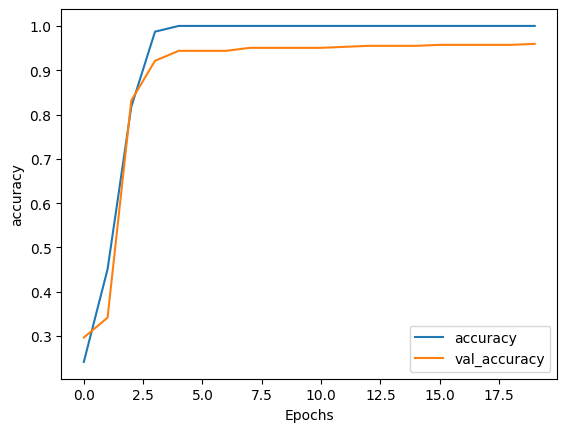

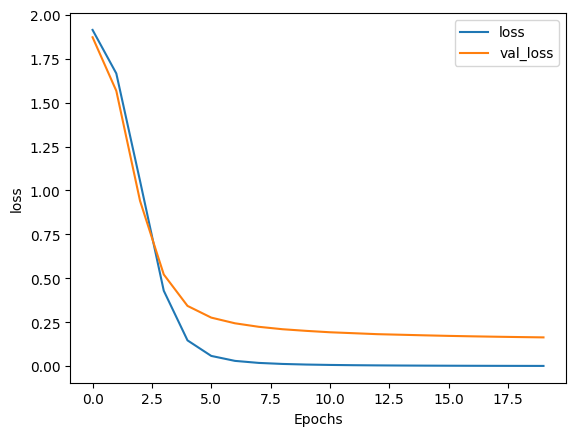

In [28]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(bbc_model_hist, "accuracy")
plot_graphs(bbc_model_hist, "loss")

In [29]:
embedding_layer = bbc_model.layers[0]
embeddings = embedding_layer.get_weights()[0] #(input_dim rows,output_dim cols)
vocabulary = vec_layer_text.get_vocabulary()

In [31]:
out_v = io.open('Models/C3W2_BBCNews/bbc_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('Models/C3W2_BBCNews/bbc_metadata.tsv', 'w', encoding='utf-8')

for i in range(2,len(vocabulary)):
  if i <= 1 :
    continue  # skip 0, it's padding. skip 1, its OOV
  vec = embeddings[i]
  word = vocabulary[i]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")

out_v.close()
out_m.close()

Upload the .tsv files to [Embedding Projector](https://projector.tensorflow.org/) to visualize